# Explore data 
 In this notebook, we take a quick look at the data to explore the variables and test out some feature engineering strategies. 

In [0]:
# Initiate spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("PopHealthRisk").getOrCreate()

In [0]:
# read spark data
df = spark.read.parquet('/Volumes/pophealthrisk/pophealthrisk/pophealthrisk/LLCP2024.parquet', header=True, inferSchema=True)
df.printSchema() # quick look at how data has been loaded

root
 |-- _STATE: double (nullable = true)
 |-- FMONTH: double (nullable = true)
 |-- IDATE: string (nullable = true)
 |-- IMONTH: string (nullable = true)
 |-- IDAY: string (nullable = true)
 |-- IYEAR: string (nullable = true)
 |-- DISPCODE: double (nullable = true)
 |-- SEQNO: string (nullable = true)
 |-- _PSU: double (nullable = true)
 |-- CTELENM1: double (nullable = true)
 |-- PVTRESD1: double (nullable = true)
 |-- COLGHOUS: double (nullable = true)
 |-- STATERE1: double (nullable = true)
 |-- CELPHON1: double (nullable = true)
 |-- LADULT1: double (nullable = true)
 |-- NUMADULT: double (nullable = true)
 |-- RESPSLC1: double (nullable = true)
 |-- LANDSEX3: double (nullable = true)
 |-- SAFETIME: double (nullable = true)
 |-- CTELNUM1: double (nullable = true)
 |-- CELLFON5: double (nullable = true)
 |-- CADULT1: double (nullable = true)
 |-- CELLSEX3: double (nullable = true)
 |-- PVTRESD3: double (nullable = true)
 |-- CCLGHOUS: double (nullable = true)
 |-- CSTATE1: double

In [0]:
# import packages
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [0]:
# subset data to plot
df_subset = df.sample(True, 0.01, seed=123)
df_subset = df_subset.toPandas() # easier to visualize a subset in a pandas df

## Target variable

<Axes: xlabel='GENHLTH', ylabel='count'>

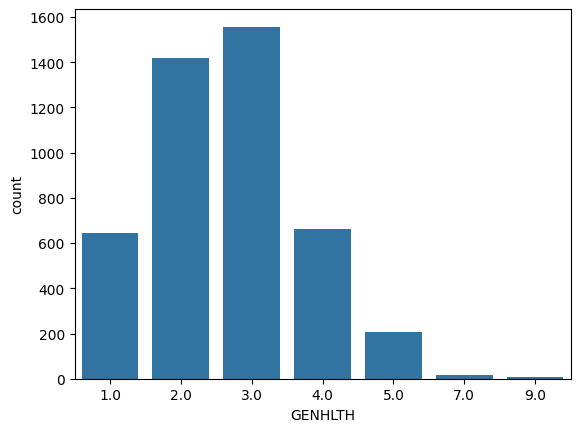

In [0]:
# General health metric
sns.countplot(df_subset, x="GENHLTH")
# As with many variables in this data set, 7 and 9 encode missing data, these values will need to be removed during data cleaning. 

<Axes: xlabel='POORHLTH', ylabel='Count'>

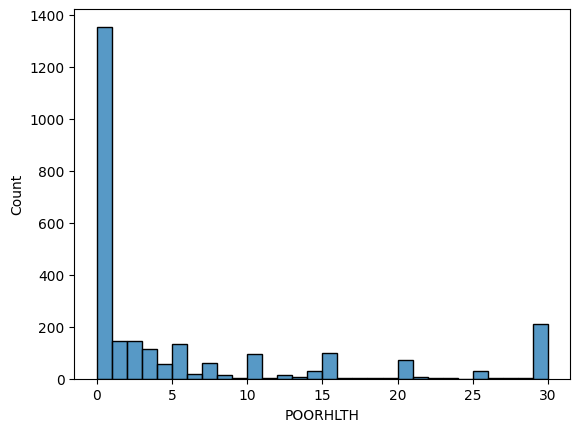

In [0]:
# Number of days of poor health
df_subset['POORHLTH'] = df_subset['POORHLTH'].apply(lambda x: 0 if x == 88 else x) # 88 means NONE
sns.histplot(df_subset[df_subset['POORHLTH']<=31], x="POORHLTH")

<Axes: xlabel='GENHLTH', ylabel='POORHLTH'>

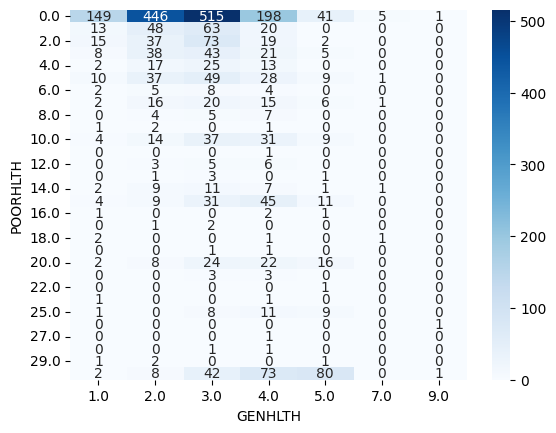

In [0]:
counts = df_subset[df_subset['POORHLTH']<=31].groupby(['POORHLTH', 'GENHLTH']).size().unstack(fill_value=0)

# Plot the heatmap
sns.heatmap(counts, annot=True, fmt='d', cmap='Blues')

<Axes: xlabel='HLTHRISK', ylabel='count'>

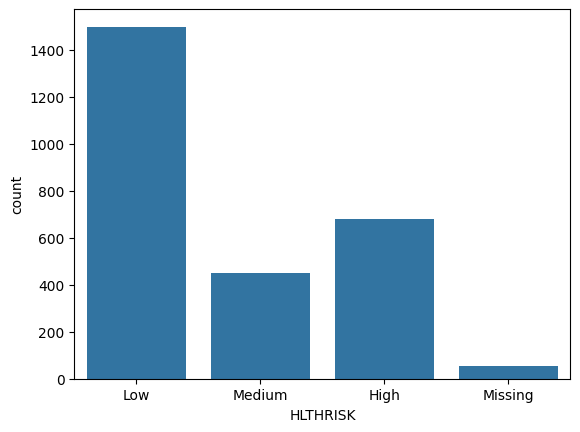

In [0]:
# Some ideas for splits for target variables.
df_subset['HLTHRISK']=pd.cut(df_subset['POORHLTH'],[0,1,5,31,np.inf], labels=['Low','Medium','High','Missing'],include_lowest=True)
sns.countplot(df_subset, x="HLTHRISK")

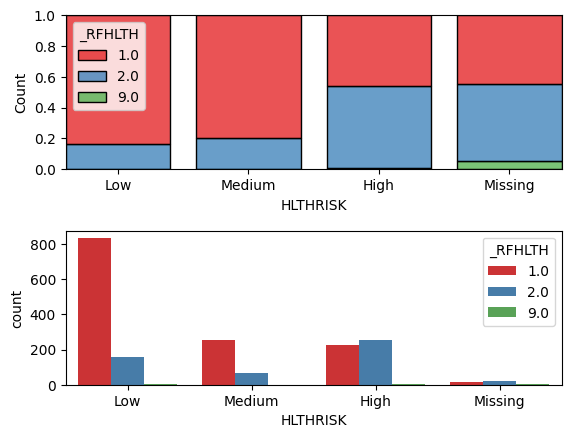

In [0]:
fig, ax =plt.subplots(2,1)
sns.histplot(df_subset, x="HLTHRISK", hue="_RFHLTH",multiple="fill", shrink=0.8, ax=ax[0],palette="Set1")
sns.countplot(df_subset, x="HLTHRISK", hue="_RFHLTH", ax=ax[1],palette="Set1")
plt.subplots_adjust(hspace=0.4)
fig.show()
# strong between High Risk and Poor health (RFHLTH=2)

## Features to include

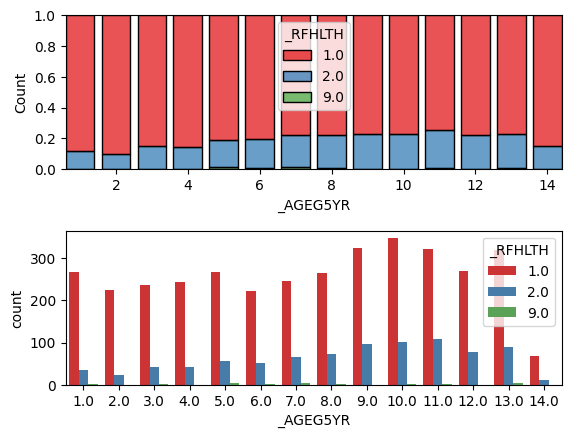

In [0]:
fig, ax =plt.subplots(2,1)
sns.histplot(df_subset, x="_AGEG5YR", hue="_RFHLTH",multiple="fill", shrink=0.8, ax=ax[0],palette="Set1",discrete=True)
sns.countplot(df_subset, x="_AGEG5YR", hue="_RFHLTH", ax=ax[1],palette="Set1")
plt.subplots_adjust(hspace=0.4)
fig.show()

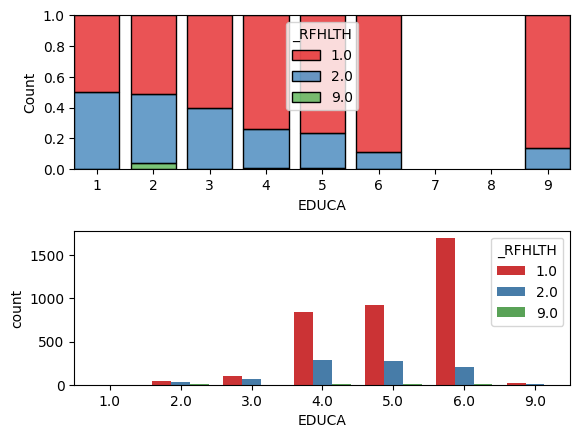

In [0]:
fig, ax =plt.subplots(2,1)
sns.histplot(df_subset, x="EDUCA", hue="_RFHLTH",multiple="fill", shrink=0.8, ax=ax[0],palette="Set1",discrete=True)
sns.countplot(df_subset, x="EDUCA", hue="_RFHLTH", ax=ax[1],palette="Set1")
plt.subplots_adjust(hspace=0.4)
fig.show()

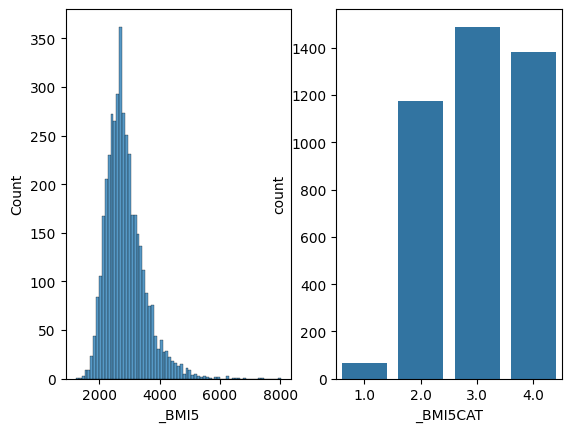

In [0]:
fig, ax =plt.subplots(1,2)
sns.histplot(df_subset, x="_BMI5", ax=ax[0])
sns.countplot(df_subset, x="_BMI5CAT", ax=ax[1])
fig.show()

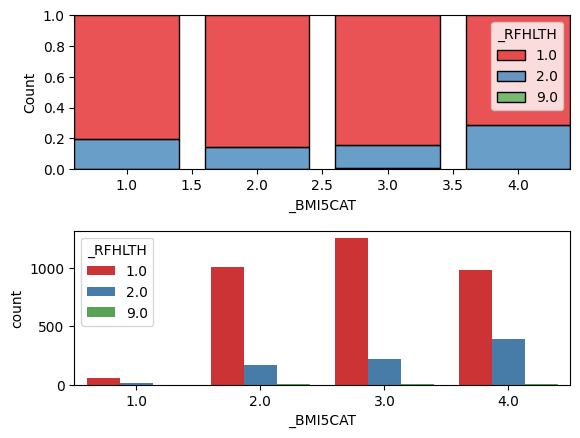

In [0]:
fig, ax =plt.subplots(2,1)
sns.histplot(df_subset, x="_BMI5CAT", hue="_RFHLTH",multiple="fill", shrink=0.8, ax=ax[0],palette="Set1",discrete=True)
sns.countplot(df_subset, x="_BMI5CAT", hue="_RFHLTH", ax=ax[1],palette="Set1")
plt.subplots_adjust(hspace=0.4)
fig.show()

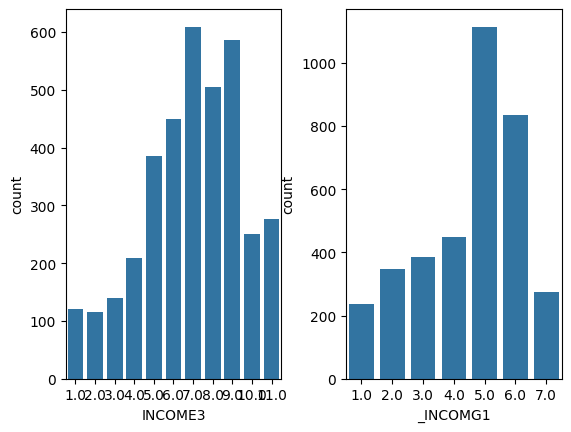

In [0]:
fig, ax =plt.subplots(1,2)
sns.countplot(df_subset[~(df_subset['INCOME3'].isin(list([77, 99])))], x="INCOME3", ax=ax[0]) # 77, 99 unknown
sns.countplot(df_subset[df_subset['_INCOMG1']!=9], x="_INCOMG1", ax=ax[1])
plt.subplots_adjust(wspace=0.3)
fig.show()

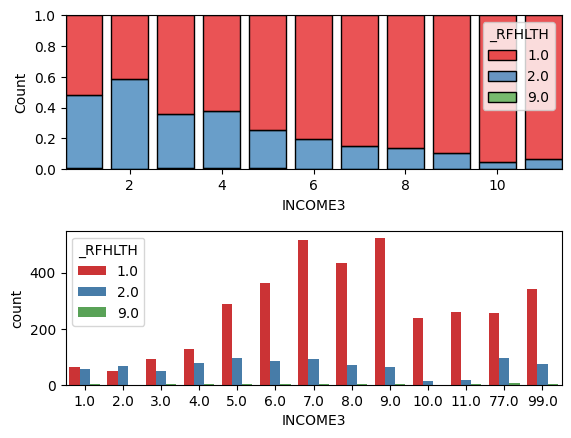

In [0]:
fig, ax =plt.subplots(2,1)
sns.histplot(df_subset[~(df_subset['INCOME3'].isin(list([77, 99])))], x="INCOME3", hue="_RFHLTH",multiple="fill", shrink=0.8, ax=ax[0],palette="Set1",discrete=True) # 77  and 99 mess with x axis and represent missing values
sns.countplot(df_subset, x="INCOME3", hue="_RFHLTH", ax=ax[1],palette="Set1")
plt.subplots_adjust(hspace=0.4)
fig.show()

In [0]:
# try simply adding up number of these serious conditions
df_subset['num_conditions']=(df_subset[['CVDINFR4','CVDCRHD4','CVDSTRK3','ASTHMA3','CHCSCNC1','CHCOCNC1','CHCCOPD3','ADDEPEV3','CHCKDNY2','HAVARTH4','DIABETE4']]==1).sum(axis=1)

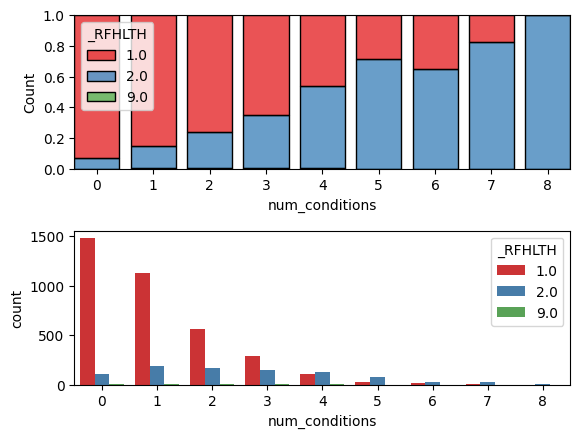

In [0]:
fig, ax =plt.subplots(2,1)
sns.histplot(df_subset, x="num_conditions", hue="_RFHLTH",multiple="fill", shrink=0.8, ax=ax[0],palette="Set1",discrete=True)
sns.countplot(df_subset, x="num_conditions", hue="_RFHLTH", ax=ax[1],palette="Set1")
plt.subplots_adjust(hspace=0.4)
fig.show()
# This is a surprisingly powerful indicator!

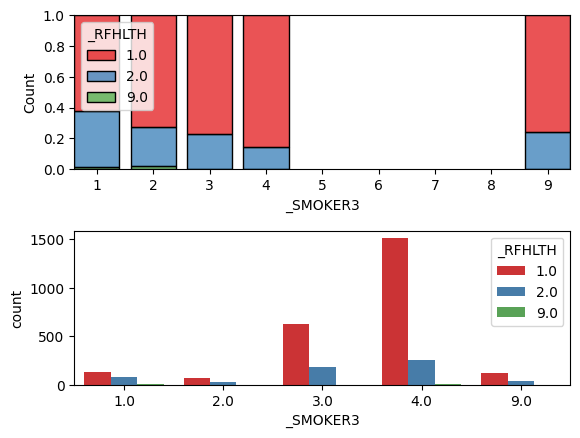

In [0]:
fig, ax =plt.subplots(2,1)
sns.histplot(df_subset, x="_SMOKER3", hue="_RFHLTH",multiple="fill", shrink=0.8, ax=ax[0],palette="Set1",discrete=True)
sns.countplot(df_subset, x="_SMOKER3", hue="_RFHLTH", ax=ax[1],palette="Set1")
plt.subplots_adjust(hspace=0.4)
fig.show()

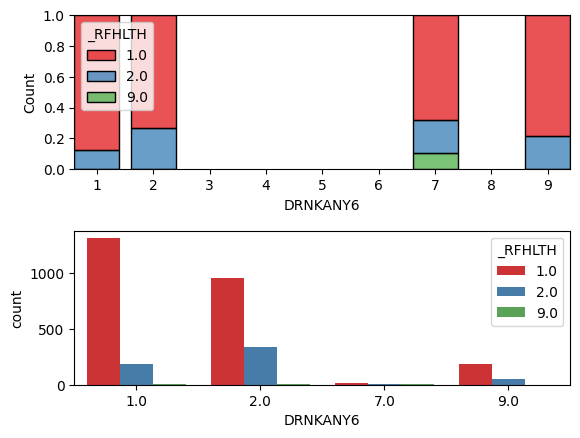

In [0]:
fig, ax =plt.subplots(2,1)
sns.histplot(df_subset, x="DRNKANY6", hue="_RFHLTH",multiple="fill", shrink=0.8, ax=ax[0],palette="Set1",discrete=True)
sns.countplot(df_subset, x="DRNKANY6", hue="_RFHLTH", ax=ax[1],palette="Set1")
plt.subplots_adjust(hspace=0.4)
fig.show()
# This is a surprising result, better health in group 2, which is have drunk alcohol in last 30 days

## Features that have little predictive value

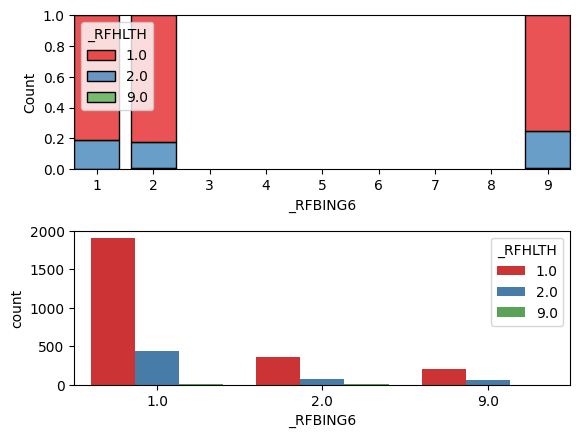

In [0]:
fig, ax =plt.subplots(2,1)
sns.histplot(df_subset, x="_RFBING6", hue="_RFHLTH",multiple="fill", shrink=0.8, ax=ax[0],palette="Set1",discrete=True)
sns.countplot(df_subset, x="_RFBING6", hue="_RFHLTH", ax=ax[1],palette="Set1")
plt.subplots_adjust(hspace=0.4)
fig.show()
# Again a surprise, this has little predictive value

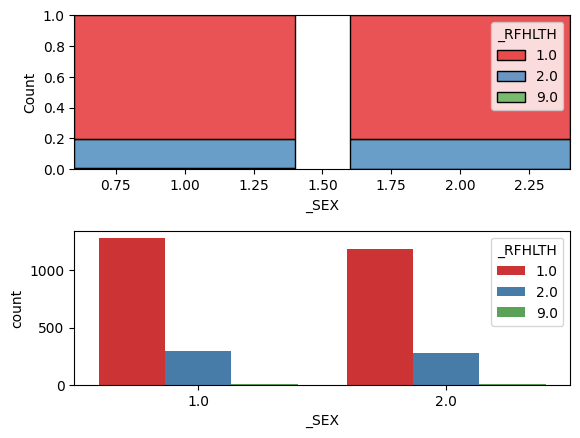

In [0]:
fig, ax =plt.subplots(2,1)
sns.histplot(df_subset, x="_SEX", hue="_RFHLTH",multiple="fill", shrink=0.8, ax=ax[0],palette="Set1",discrete=True)
sns.countplot(df_subset, x="_SEX", hue="_RFHLTH", ax=ax[1],palette="Set1")
plt.subplots_adjust(hspace=0.4)
fig.show()
# this has no predictive value

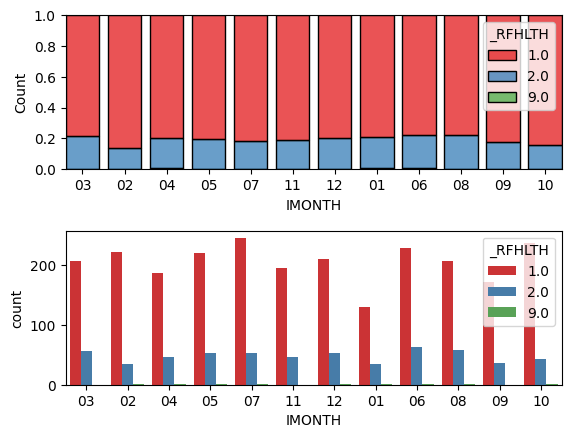

In [0]:
fig, ax =plt.subplots(2,1)
sns.histplot(df_subset, x="IMONTH", hue="_RFHLTH",multiple="fill", shrink=0.8, ax=ax[0],palette="Set1",discrete=True)
sns.countplot(df_subset, x="IMONTH", hue="_RFHLTH", ax=ax[1],palette="Set1")
plt.subplots_adjust(hspace=0.4)
fig.show()

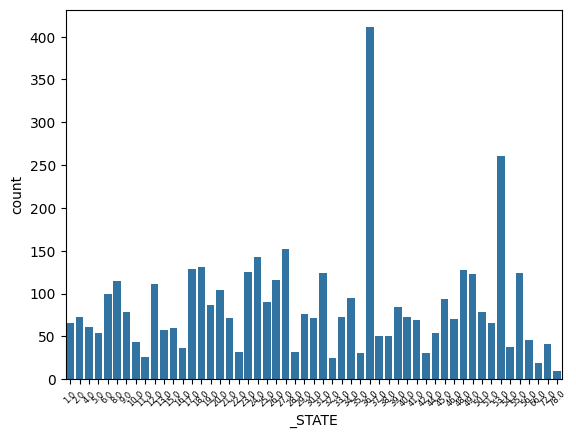

In [0]:
# not very evenly distributed, may be hard to interpret
sns.countplot(df_subset, x="_STATE")
plt.xticks(rotation=45, size=6)
plt.show()

## Add in census data
We will import census data to establish income relative to poverty threshold for a given size of household.

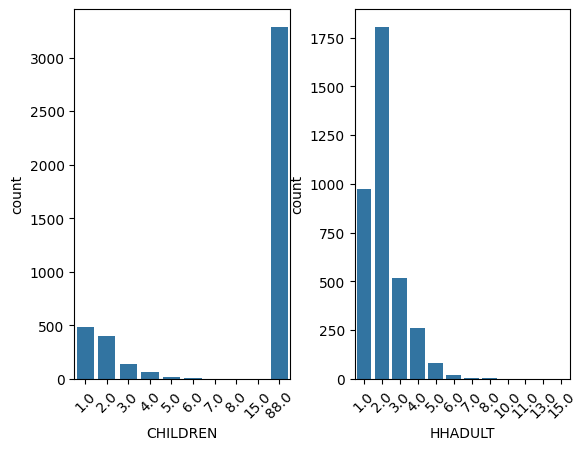

In [0]:
fig, ax =plt.subplots(1,2)
sns.countplot(df_subset[~(df_subset['CHILDREN'].isin(list([77, 99])))], x="CHILDREN", ax=ax[0]) # 77, 99 unknown
sns.countplot(df_subset[~(df_subset['HHADULT'].isin(list([77, 88,99])))], x="HHADULT", ax=ax[1]) # 77, 99 unknown
plt.subplots_adjust(wspace=0.3)
for a in ax:
    a.tick_params(axis='x', rotation=45)
fig.show()

<Axes: xlabel='CHILDREN_mod', ylabel='count'>

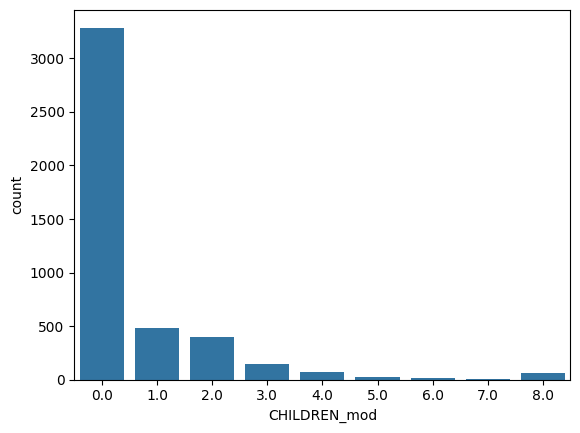

In [0]:
# we need to tidy up CHILDREN variable, as 88 means none, 99 means missing and max can be used for poverty line is 8

def modify_children(x):
    if x==88:
        return 0
    elif x ==99:
        return np.nan
    else:
        return min(8,x)
df_subset['CHILDREN_mod']=[modify_children(x) for x in df_subset['CHILDREN']]
sns.countplot(df_subset, x="CHILDREN_mod")

<Axes: xlabel='ADULT_mod', ylabel='count'>

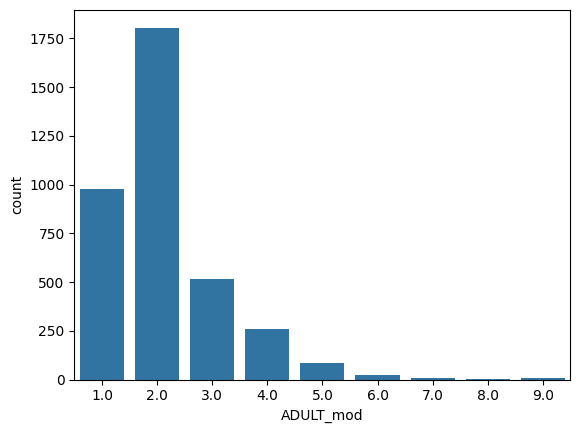

In [0]:
# we also need to tidy up HHADULT variable, as 77,88,99 mean missing and max can be used for poverty line is 9

def modify_adults(x):
    if x in [0,77,88,99] or np.isnan(x):
        return np.nan
    else:
        return min(9,x)
df_subset['ADULT_mod']=[modify_adults(x) for x in df_subset['HHADULT']]
sns.countplot(df_subset, x="ADULT_mod")

In [0]:
poverty_df = pd.read_csv('/Volumes/pophealthrisk/pophealthrisk/pophealthrisk/thresh24.csv')
# rename to allow merge
poverty_df=poverty_df.rename(columns={'household':'ADULT_mod', 'children':'CHILDREN_mod','threshold':'poverty_threshold'})

In [0]:
# discretize to levels in INCOME3
bins=[0,10000,15000,20000,25000,35000,50000,75000,100000,150000,200000,np.inf]
poverty_df['poverty_threshold_conv']=pd.cut(poverty_df['poverty_threshold'],bins, labels=[x for x in range(1,12)])
poverty_df['poverty_threshold_conv']=pd.factorize(poverty_df['poverty_threshold_conv'])[0] + 2

In [0]:
df_subset=df_subset.merge(poverty_df, on=['ADULT_mod','CHILDREN_mod'])

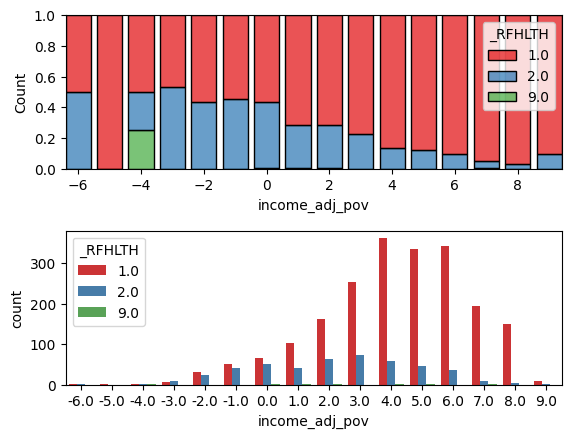

In [0]:
def remove_7799(x):
    if x in[77,99]:
        return np.nan
    else:
        return x
df_subset['INCOME3_adj']=[remove_7799(x) for x in df_subset['INCOME3']]
df_subset['income_adj_pov'] = df_subset['INCOME3_adj']-df_subset['poverty_threshold_conv']
fig, ax =plt.subplots(2,1)
sns.histplot(df_subset, x="income_adj_pov", hue="_RFHLTH",multiple="fill", shrink=0.8, ax=ax[0],palette="Set1",discrete=True)
sns.countplot(df_subset, x="income_adj_pov", hue="_RFHLTH", ax=ax[1],palette="Set1")
plt.subplots_adjust(hspace=0.4)
fig.show()